In [23]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Jury Panels (Review)
We are going to pick up from the previous lecture,
<img src = 'jury.jpg' width = 700\>
We had the diagram above that explains that

1. We start with having eligible jurors in a County
2. Then the county selects a list of eligible residents. Some of the requirements might be:
    * Able to speak English
    * Be a resident of that county
    * Not having a felony
3. From the eligible residents, they **supposedly pick at random** people be in the jury panel
4. and finally, the final jury.

The goal is to create panels that are representative of the people of that county. 

In the case of Swain v. Alabama, the population of the county had 26% black, while the panel that Swain had in his court case had only 8 black out of 100 people. 

## Is The Actual Jury Panel Likely?
We can use the methods that we learn in class to see if the panel of 8 black out of 100 people was likely to occur if we drew at random the population of eligible jurors.

Don't worry too much about the codes. Focus on the high level steps of what we are trying to do.

What's the probability of getting the actual panel with 8/100 black jurors?

High-level Steps:
1. Start with the distributions of eligible jurors and the actual panel
    * Eligible jurors: 26% black
2. Draw panels at random from the eligible jurors (population)
    * Draw 100 people, see what it looks like. Draw another 100, see what it looks like, and so on.
3. See if actual panel is likely to occur if we drew at random from the population
    * If we draw panels at random from population and none of them have 8 or less blacks, then we can say that the actual panel is unlikely to occur by chance

### Step 1: Distributions of population and sample

In [24]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


### Step 2: Draw panels at random from population
Calling the function `random_jury_panel` gives us the original `swain` table with an additional `Random` column

In [25]:
population_distribution = swain.column('Eligible')
panel_size = 100

def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,25%
Other,74%,92%,75%


A quicker method is to use `sample_proportions` method.

In [26]:
population_distribution = swain.column('Eligible')
panel_size = 100

def randomPanelQuicker():  
    return swain.with_column(
    'Random', 
    sample_proportions(100, population_distribution)).set_format(
        'Random', PercentFormatter(0))

randomPanelQuicker()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,25%
Other,74%,92%,75%


### Step 3: See if sample panel is unlikely
Simulate calling the function above multiple times, calculate the TVD of each `Random` vs. `Eligible`, and compare with TVD of `Panel` vs. `Eligible`.

Recall **Total Variation Distance** is a measure of how different 2 distributions are. The greater the TVD value, the more difference.

In [27]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

Above, our original TVD of `Panel` vs. `Eligible` is 0.18.

Below, we draw 1000 panels, each panel contains 100 people. We compute the TVD of each sample panel against the `Eligible`.

In [28]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = randomPanelQuicker()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & random samples', tvds)
results

TVD between the population & random samples
0.06
0.05
0.03
0.01
0.07
0.01
0.01
0.02
0.05
0


And we construct a histogram out of the data above,

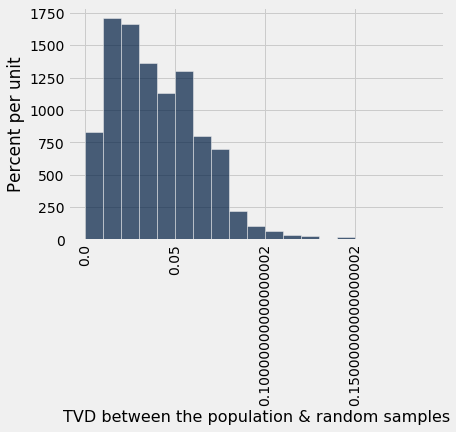

In [29]:
results.hist(bins=np.arange(0, 0.2, 0.01))

The histogram above shows the TVD values that are likely to occur if we draw random panels from the population. It seems that the most often occuring TVD are within the range 0 to 0.075. The furthest TVD (and slightly unlikely) is around 0.13. 

Compare the histogram above with the TVD that we obtained from `Panel` vs. `Eligible` (0.18), marked below with the red dot.

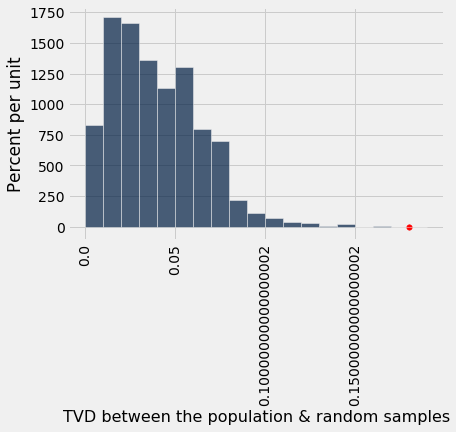

In [30]:
results.hist(bins=np.arange(0, 0.2, 0.01))
plt.scatter(0.18, 0, color='red', s=30);

We can see that 0.18 is far on the right side, which shows that the actual panel is unlikely to be drawn at random from eligible jurors. 

Unfortunately for Swain, in 1962 the Supreme Court ruled that the jury panel were fair. In 1980, parts of the ruling were overturned and the laws were adjusted to become more fair.

That was on 1962. How about nowadays?

# Alameda County Juries
In 2010, the ACLU releases a report of ethnic disparity in Alameda County. They analyzed the jury panels in Alameda County. The following is the report, 

In [31]:
panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


ACLU analyzed 11 panels of felony trials. They interviewed each panelist individually and took note of their ethnicities. Above is the distribution that they found from the panels. We can visualize the data above with a bar chart.

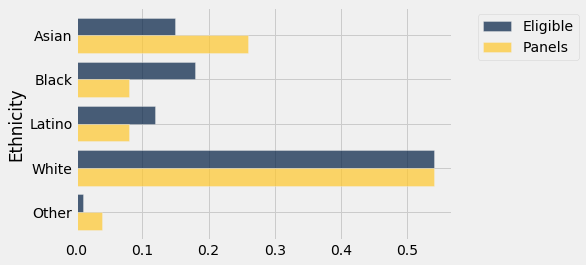

In [32]:
panels.barh('Ethnicity')

From the bar chart above, we see that the panels have more asians, less black and latino, about the same number of white, and slightly more others compared to the eligible population. We can ask the same question from the Swain case. It's not exactly the same as asking whether the panels were fair, but we can still ask:

### Were these panels likely to be drawn at random from the population?
The steps are similar to the Swain's case, which is:

## Step 1: Distributions of Population and Sample

In [33]:
panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


## Step 2: Draw panels at random from the population

Start with the `panels` table,

In [45]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


We want to draw panels at random from the `Eligible`.

The panel size from the `Panels` column are actually 1453 since they consist of 11 trials in which each trial consist of 150 panelist. 

As done before, select the `Ethnicity` column,

In [35]:
panels.select('Ethnicity')

Ethnicity
Asian
Black
Latino
White
Other


And once again, we can take a `sample` of people out of the `Ethnicity` above.

In [36]:
panels.select('Ethnicity').sample(10000)

Ethnicity
Black
Other
Latino
Asian
Asian
Latino
Other
White
Latino
White


However, again the probability of getting all 5 ethnicities are equal. If we count the number of times each `Ethnicity` appear,

In [37]:
panels.select('Ethnicity').sample(10000).group('Ethnicity')

Ethnicity,count
Asian,1996
Black,2023
Latino,2019
Other,1986
White,1976


We will see that the amount of people drawn from each ethnicity is about the same. This is not a representation of a panel drawn from the population. We want to adjust the likelyhood of each ethnicity appearing so that the panel would reflect a panel drawn at random from population.

We start by taking the values from `Eligible` column,

In [38]:
panels.column('Eligible')

array([0.15, 0.18, 0.12, 0.54, 0.01])

Then take a `sample` with the weights as specified above.

In [39]:
panels.select('Ethnicity').sample(10000, weights = panels.column('Eligible')).group('Ethnicity')

Ethnicity,count
Asian,1510
Black,1723
Latino,1255
Other,96
White,5416


Above, we get about the correct proportion of each ethnicity. Note that the `group` method automatically sorts the `Ethnicity`. In the original `panels` table, `Other` was at the bottom. In the table above, `White` is at the bottom. 

Now that we know the proportion is correct, we can draw a panel with the size 1453!

In [40]:
panels.select('Ethnicity').sample(1453, weights = panels.column('Eligible')).group('Ethnicity')

Ethnicity,count
Asian,218
Black,274
Latino,179
Other,11
White,771


And we can convert the table above into proportions and put the proportion as a new column in the original table.

There is a short way of doing the steps above: the function `proportions_from_distribution`.

In [41]:
proportions_from_distribution?

#### Pro Tip: If we want to use a function but we happened to forgot what we should put as the arguments, hold `Shift` and press `Tab` inside the parentheses `()`. Press `Tab` one more time to expand the explanation box.

In [42]:
proportions_from_distribution()

TypeError: proportions_from_distribution() missing 3 required positional arguments: 'table', 'label', and 'sample_size'

As we can see from the function documentation, the function `proportions_from_distribution` takes a table, the column label that contains the value of proportions, and the sample size.

In [67]:
panel_size = 1453
proportions_from_distribution(panels, 'Eligible', panel_size)

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,0.15554
Black,18%,8%,0.163111
Latino,12%,8%,0.138334
White,54%,54%,0.528562
Other,1%,4%,0.0144529


As can be seen above, the function draws a random sample with the assigned proportion and adds the value as a column to the original table.

We can change the format from decimals to percentage to make the table look better.

In [68]:
sample_1 = proportions_from_distribution(panels, 'Eligible', panel_size)
sample_1.set_format([1, 2, 3], PercentFormatter(0))

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,14%
Black,18%,8%,18%
Latino,12%,8%,13%
White,54%,54%,54%
Other,1%,4%,1%


Now that we have created the table above, we can create a visualization to compare each distribution.

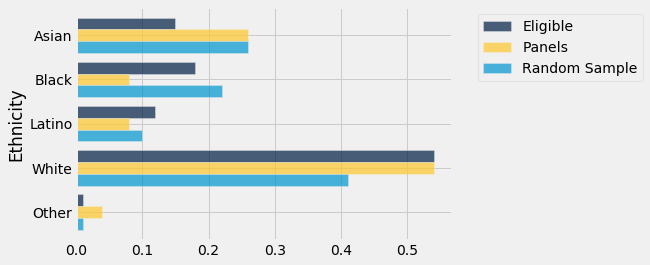

In [48]:
sample_1.barh('Ethnicity')

Above, we can see that the length of the `Random Sample` bars are similar to those of `Eligible`. This means most of the time, we should get a random sample that resembles the population. 

# Empirical Distribution
Recall in the past lecture, we discussed 2 types of distribution: **probability** distribution and **empirical** distribution. We used the "roll-a-die" as representation.

"Roll a die 6,000 times and we should see about 1,000 of those to be 6. The probability of each face to occur is equally likely, which is 1/6." - This is the mathematical probability distribution of each face to occur.

"Roll a die 6,000 times. Count each number of times 6 appears. Based on that result, we can make an estimate of how likely 6 is going to show up." - This is empirical distribution

## Distribution of a Statistic
We are going to go over some terms about the distribution of a statistic.

1. `Statistic`: A quantity for a particular sample. 
    * When we roll a die 6,000 times,
        * The sample is 6,000 die rolls
        * The `statistic` is the number of 6s that we get
    
2. `Distribution`: The chance of each outcome of sampling

This not the same as the chance of getting each face in a die roll. The chance of getting each face in a die roll is 1/6. What we want to know is the chance of getting 6s in 6,000 rolls. 
* We could get no 6s at all. We could get all 6s for every single roll. The probability of any of these happening is not 0, but extremely small. 


* Between 0 to 6,000, there can be any number of 6 that can show up. We can get 100 6s, or 2,000 6s.
    * Each of these outcome of sampling has a chance or `distribution`
    * If we calculate the chance precisely using the laws of probability, we can get the `sampling distribution`

3. `Sampling Distribution`: Chance of each value of a statistic (computed for all possible samples)
    * For a particular sample, what is the probability of obtaining the result of our statistic?
        * If we roll a die 6,000 times, what is the probability of getting 1,000 6s? What is the probability of getting 2,000 6s? or no 6s at all?
    * This is also known as **the probability distribution of the statistic**
    
4. `Empirical Distribution`: Observations of a statistic (computed from some samples drawn at random)
    * Roll a die 6,000 times and count how many 6s appear. Repeat this multiple times
        * Turns out we find 1000 6s pretty often among the repetitions.
        * We found 999 6s and 1001 6s quite often too
        * Not as many as 700 6s and 1300 6s
    * As we roll the die and obtain more samples, we can get closer to the `sampling distribution` using the **law of large numbers**
    
For clarification regarding distributions:
1. `Probability distribution` of each face of a die
    * Each face of a die has 1/6 chance of appearing

2. `Probability distribution of the statistic`: What's the probability of a certain number of times 6s appear in 6,000 rolls?

Both of the distributions above can be approximated through sampling:
* Roll a die
* See how likely each face to occur

For `Empirical Distribution`:
* Roll a die 6,000 times
* Count how many 6s
* Repeat multiple times 

Make sure to know which distribution that is currently worked on.

In Alamada Jury Panel case, it is very difficult to compute the precise probability distribution. For cases like this, it is much easier to draw samples and see what happens. 

## Alameda County Jury Panels

1. `Statistic`: the TVD between a sample and the population distribution
2. `Distribution` : the chance of each possible TVD
3. `Sampling Distribution`: the exact probability of each TVD
    * It is possible to draw a panel that looks exactly like the population. In that case, the TVD will be 0
    * `Sampling distribution` and `probability distribution` are terms that can be used interchangibly 

4. `Empirical Distribution`: Probability of each TVD using simulated panels from the population

Back to our sample of panels

In [69]:
sample_1

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,14%
Black,18%,8%,18%
Latino,12%,8%,13%
White,54%,54%,54%
Other,1%,4%,1%


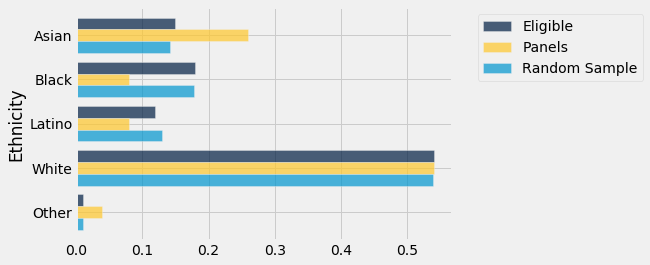

In [70]:
sample_1.barh(0)

Above we have a sample. We can compute and see if the TVD between this sample and the population is likely.

## Step 3: See if sample panel is likely

In [57]:
table_tvd(sample_1, 'Eligible','Random Sample')

0.05000000000000001

Above is a TVD of one sample. We want the TVD of multiple samples, thus we need simulate taking the random sample multiple times. We will do 1,000 repetitions.

In [71]:
repetitions = 1000 # Also the number of panels we will get
tvds = make_array()

for i in np.arange(repetitions):
    # 'sample' is a table obtained from calling the 'proportions_from_distribution'
    sample = proportions_from_distribution(panels, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(sample, 'Eligible', 'Random Sample'))

tvds

array([0.0227254 , 0.01561597, 0.0178596 , 0.01824501, 0.00889883,
       0.02507226, 0.00460427, 0.01480385, 0.00836201, 0.02604267,
       0.01818995, 0.02676531, 0.01893324, 0.01333792, 0.02410186,
       0.01434962, 0.02075017, 0.00836201, 0.02269787, 0.01725396,
       0.01658637, 0.01203716, 0.03095664, 0.03818995, 0.01656573,
       0.02069511, 0.01377839, 0.0233861 , 0.02126635, 0.01728149,
       0.02213352, 0.01094288, 0.03511356, 0.00916036, 0.0248245 ,
       0.02779078, 0.02195458, 0.02278734, 0.0213214 , 0.01641432,
       0.01002753, 0.00952512, 0.01515485, 0.0237371 , 0.01584308,
       0.01796284, 0.02300757, 0.02511356, 0.0113627 , 0.02123193,
       0.0135031 , 0.0136958 , 0.02269787, 0.00698555, 0.02415692,
       0.01683414, 0.01203716, 0.0151755 , 0.02567791, 0.01687543,
       0.01958706, 0.00790778, 0.01094288, 0.02192017, 0.0106607 ,
       0.01656573, 0.0215967 , 0.01479009, 0.01960771, 0.009298  ,
       0.02209222, 0.01342739, 0.00956641, 0.01136958, 0.02264

Once again, for visualization purpose, we can put the resulting array above into a table.

In [72]:
repetitions = 1000 # Also the number of panels we will get
tvds = make_array()

for i in np.arange(repetitions):
    # 'sample' is a table obtained from calling the 'proportions_from_distribution'
    sample = proportions_from_distribution(panels, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(sample, 'Eligible', 'Random Sample'))

results = Table().with_columns('TVD between population and random sample', tvds)
results

TVD between population and random sample
0.00406056
0.0238747
0.0118032
0.0152512
0.018596
0.0151273
0.0269098
0.0147832
0.0224501
0.0161803


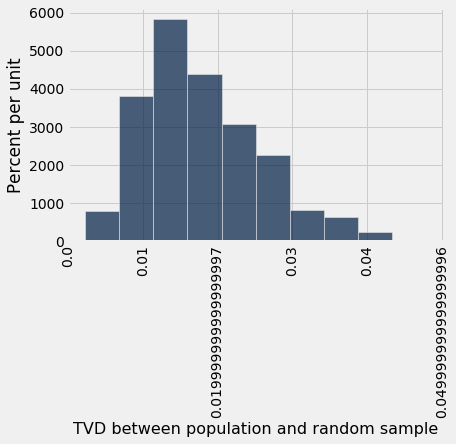

In [74]:
results.hist()

Above is the empirical distribution of the TVDs. We drew panels at random, took the TVD of each panel vs. the population. From the histogram, we can see which TVD is likely.

Below we have a function that illustrates what the empirical distribution would look like if we change the number of samples to take.

In [75]:
def hist_n_samples(tbl, n, bins = None):
    tbl.take(np.arange(n)).hist(bins = bins)
    plt.ylim(0, 50)
    plt.show()

In [82]:
_ = interact(hist_n_samples, tbl=fixed(results), n=[1, 10, 100, 500, 1000], bins=fixed(np.arange(0, 0.2, 0.01)))

interactive(children=(Dropdown(description='n', options=(1, 10, 100, 500, 1000), value=1), Output()), _dom_cla…

Above, as we increase `n`, the number of samples, the histogram resembles more of the population distribution.

Now, if we look back to the original panel,

In [83]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


We can calculate the TVD of our `Actual Panel` vs. `Eligible`,

In [84]:
table_tvd(panels, 'Eligible', 'Panels')

0.14

Above, our TVD between actual panel and the population is 0.14, which is outside the range of the histogram! This implies that it is unlikely that these actual panels were taken at random from the eligible population. 

This analysis is enough to give us suspicion, but not enough to say that the jury was unfairly selected.

If we stick with the initial assumption that,

In [85]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


Assumption: We selected at random panels from the `Eligible`

Then the `Panels` is unlikely to occur by chance.

Now recall that our panel size is 1453.

In [86]:
panel_size

1453

## Discussion Question: How do you think our analysis would change if the jury panels only had 50 people?

In [87]:
panel_size = 50

We can do the simulation once again and find out,

In [91]:
repetitions = 1000 # Also the number of panels we will get
tvds = make_array()

for i in np.arange(repetitions):
    # 'sample' is a table obtained from calling the 'proportions_from_distribution'
    sample = proportions_from_distribution(panels, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(sample, 'Eligible', 'Random Sample'))

results_50 = Table().with_columns('TVD between population and random sample', tvds)
results_50

TVD between population and random sample
0.11
0.07
0.07
0.05
0.04
0.05
0.06
0.07
0.15
0.06


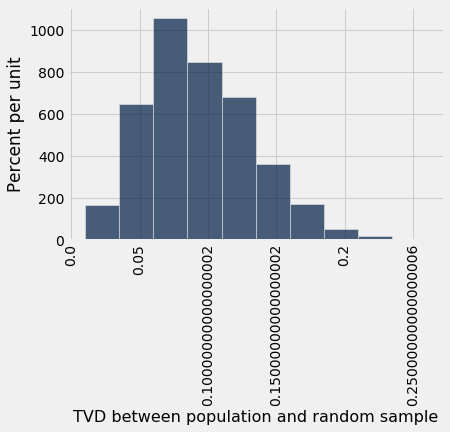

In [92]:
results_50.hist()

And we can make an interactive version of the histogram above to see how the histogram changes with varying number of panels taken.

In [95]:
_ = interact(hist_n_samples, tbl=fixed(results_50), n=[1, 10, 100, 200, 500, 1000], bins=fixed(np.arange(0, 0.2, 0.01)))

interactive(children=(Dropdown(description='n', options=(1, 10, 100, 200, 500, 1000), value=1), Output()), _do…

The histogram becomes more spread out! Why?

1. **As our sample size become smaller, it is more likely to obtain a sample that looks different from the population and thus, the TVD will become greater.**

2. As the sample size increases, it is more likely to obtain a sample that resembles the population and thus, the TVD will become smaller. 

## Addendum: Alameda County Race & Ethnicity Distribution
When the ACLU released the report, they used Census data from 2000. Now that the 2010 Census data is available, we can use it to analyze the ethinicity breakdown.

In [96]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

Race,Population
White,42.98%
African American,12.61%
Asian,26.13%
AIAN,0.65%
NHPI,0.85%
Some Other Race,10.76%
Two or more Races,6.03%


Ethnicity,Population
Hispanic or Latino,22.51%
Not Hispanic or Latino,77.49%


Compared to the original table,

In [97]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


Our analysis used an assumption that the population looked like the `Eligible` column in the data above. If it turned out the population didn't look like the data above, our analysis would be questionable.

What we have done so far is called **Hypothesis Testing**.

# Hypothesis Testing

## Testing a Hypothesis
In testing a hypothesis, the most often asked question is, "Does our sample look like the population?"

These are the official steps that we need to do when we test a hypothesis (e.g. whether the jury panel is fair, whether or coin or die is fair)

#### Step 1: The Hypothesis
1. A test chooses between 2 views of how data were generated
2. `Null hypothesis` proposes that data were generated at random. For example, `null hypothesis` says:
    * We drew our panel at random from the population
    * Our coin is fair to begin with
3. `Alternative hypothesis` proposes some effect other than chance. For example, `Alternative hypothesis` says:
    * The jury panel looks different from the population. This was not due to random chance. This was due to some random factor that we did not take into account.
    
#### Step 2: Choose the `Test Statistic` or `The measure of difference between the samples` - a value that can be computed for the data and for samples
1. In Alameda Panel case, it was the TVD

#### Step 3: The Sampling Distribution of the Test Statistic
1. What the test statistic might be if the null hypothesis were true
    * Draw samples at random and look at the distribution of the statistic
        * In Alameda case, we looked the distribution of TVDs and see if the actual result is likely to happen
    * Approximate the sampling distribution by an empirical distribution

## Recap: Alameda County Hypothesis Testing
We analyzed if the jury panel looks like a panel selected at random from the population.

#### Step 1: The Hypothesis
1. `Null hypothesis`: The panels of juror was selected at random from the eligible juror population
    * Any differences between the ethnicity distributions of panel and population are due to change
2. `Alternative hypothesis`: The panel was not selected at random

#### Step 2: The Test Statistic

`Test statistic`: the TVD between a sample panel and the population distribution

#### Step 3: The Sampling Distribution of the Test Statistic
1. Simulate drawing sample panels from the population
2. See if the actual panel TVD is likely